In [1]:
%matplotlib notebook
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scanpy as sc
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.grid'] = False

Populating the interactive namespace from numpy and matplotlib


In [3]:
pathToCounts = './counts.h5ad'
pathToCellData = './cell_annotation.csv'

In [52]:
counts = sc.read(pathToCounts)
cell_annotation = pd.read_csv(pathToCellData,index_col = 0)
counts.obs = cell_annotation.loc[counts.obs.index,:]

### Panel a 

In [68]:
cmap_subclass = dict(zip(cell_annotation.subclass, cell_annotation.color_subclass))

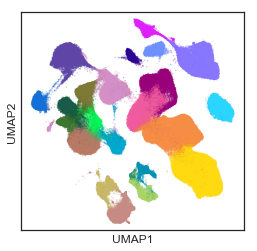

In [71]:
#Plot umap
x = cell_annotation.umap_x
y = cell_annotation.umap_y

fig = plt.figure(figsize = (4,4))
sns.set(font_scale=1)
sns.set_style("white")
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, c=cell_annotation["subclass"].apply(lambda x: cmap_subclass[x]), alpha=0.6, s=0.05, rasterized = True)

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP2") 
plt.xlabel("UMAP1")

ax1.axis('equal')
#f.savefig('./umap.pdf',dpi = 300, bbox_inches = 'tight', transparent=False)
plt.show()

### Panel b 

In [72]:
countsDF = pd.DataFrame(counts.X, index = counts.obs.index.values, columns = counts.var.index.values)
countsDF['label'] = counts.obs['label']

In [73]:
countsMean = countsDF.groupby('label').mean()
countsMeanZ = pd.DataFrame(preprocessing.scale(countsMean), index = countsMean.index, columns = countsMean.columns)

In [74]:
Z = linkage(countsMeanZ, 'ward')

In [75]:
groups = counts.obs.loc[:,['subclass','label']].groupby(['subclass','label'])
groupDict = dict()
for k,v in groups:
    groupDict[k[1]] = k[0]
# class_label_colors = {'Other':'y', 'Glutamatergic':'m', 'GABAergic':'c'}

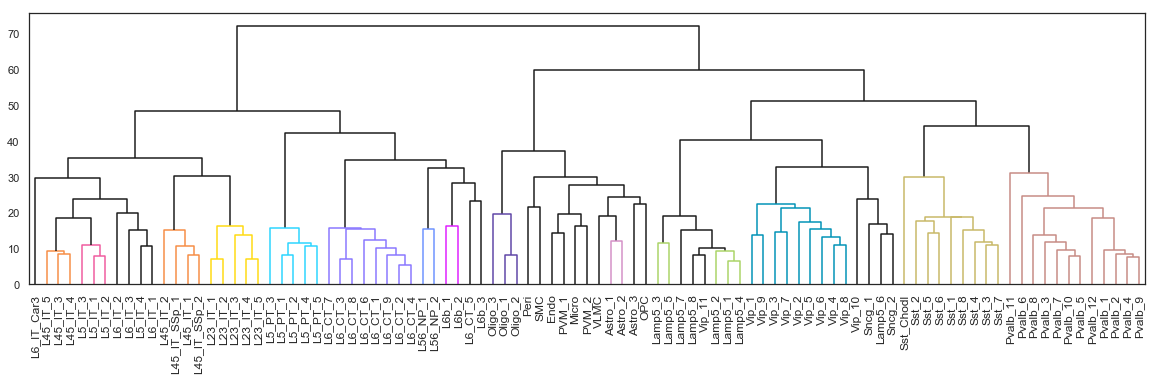

In [76]:
# Color mapping
dflt_col = "k"   # Unclustered gray
D_leaf_colors = dict(zip(countsMeanZ.index, [[cmap_subclass[groupDict[x]]] for x in countsMeanZ.index]))
numToType = dict(zip(range(len(countsMeanZ.index.values)), countsMeanZ.index.values))
# notes:
# * rows in Z correspond to "inverted U" links that connect clusters
# * rows are ordered by increasing distance
# * if the colors of the connected clusters match, use that color for link
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors[numToType[x]][0]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

# Dendrogram
f,axs = plt.subplots(1,1,figsize = (20,5))
D = dendrogram(Z=Z, labels=countsMeanZ.index, color_threshold=None,
  leaf_font_size=12, leaf_rotation=90, link_color_func=lambda x: link_cols[x])
#f.savefig('./dend.pdf',dpi = 300, bbox_inches = 'tight', transparent=False)

### Panel e 

In [77]:
pathToTracingData = './tracing_panel_e.csv'

In [78]:
TracingData = pd.read_csv(pathToTracingData,index_col = 0)

In [84]:
clusterToPlot = [ 'L23_IT_1','L23_IT_2','L23_IT_3', 'L23_IT_4', 'L23_IT_5','L45_IT_SSp_1','L45_IT_SSp_2','L45_IT_1', 'L45_IT_2', 'L45_IT_3','L45_IT_4', 'L45_IT_5', 'L5_IT_1','L5_IT_2', 'L5_IT_3', 'L5_IT_4', 'L6_IT_1','L6_IT_2','L6_IT_3', 'L6b_1', 'L6b_2','L6b_3']
targets = ['MOs','SSp','TEa/ECT/PERI']

xDict = dict(zip(clusterToPlot, range(len(clusterToPlot))))
yDict = dict(zip(targets, range(len(targets))))
TracingData['x'] = TracingData['cluster'].map(xDict)
TracingData['y'] = TracingData['target'].map(yDict)

[Text(0, 0, 'MOs'), Text(0, 0, 'SSp'), Text(0, 0, 'TEa/ECT/PERI')]

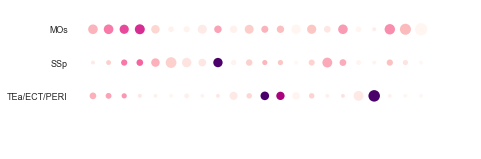

In [102]:
f,axs = plt.subplots(1,1,figsize = (7,7*0.35))

maxSize = 150
minSize = maxSize * 0.1
TracingData['size_scaled'] = TracingData['fraction_cluster'] * maxSize
mask = TracingData['size_scaled'] < minSize
TracingData['size_scaled'] = TracingData['size_scaled'].where(~mask, other = minSize)

plt.scatter(TracingData['x'], TracingData['y'],
            c = TracingData['fraction_target'], cmap = 'RdPu',vmin = 0, vmax = 0.2,
            s = TracingData['size_scaled'], edgecolors='none')


axs.set_ylim(len(targets)+0.5,-0.5)
axs.set_xlim(-1, len(clusterToPlot)+2)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.get_xaxis().set_ticks([])
axs.set_yticks(range(len(targets)))
axs.set_yticklabels(targets, fontsize = 9)
#plt.colorbar()
#f.savefig('./dot.pdf',dpi = 300, bbox_inches = 'tight', transparent=False)